# Кластеризация Sentiment140 Dataset

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Загрузка данных
df_init = pd.read_csv('../data/twitter.csv', encoding='latin-1')

df_init.columns = ['target', 'ids', 'date', 'flag', 'user', 'text' ]

df = df_init.sample(frac=0.01, random_state=42)

print(df.shape)

(16000, 6)


In [66]:
df.head()

,target,ids,date,flag,user,text
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"


In [67]:
# Векторизация текста
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(df['text'].tolist())

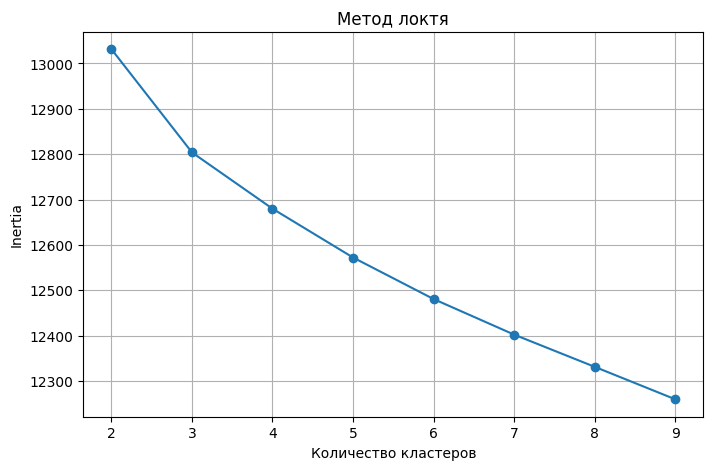

In [68]:
# Метод локтя для KMeans
inertias = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.grid()
plt.show()

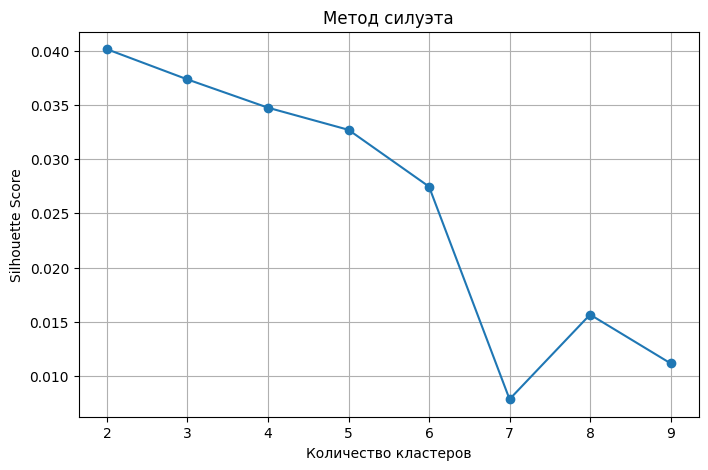

In [69]:
# Метод силуэта для KMeans
silhouette_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Метод силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [70]:
# Выбираем оптимальное количество кластеров
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['kmeans_label'] = kmeans.fit_predict(X)

# Оценка ARI
ari_kmeans = adjusted_rand_score(df['target'], df['kmeans_label'])
print(f'Adjusted Rand Index (KMeans): {ari_kmeans:.4f}')

Adjusted Rand Index (KMeans): 0.0183


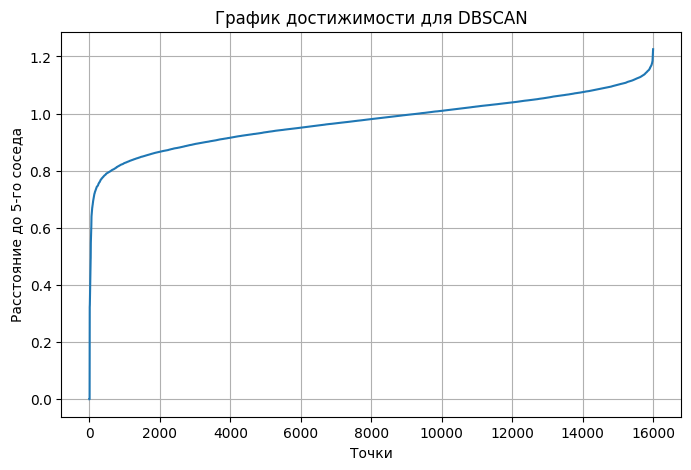

In [71]:
# Подбор eps для DBSCAN
nn = NearestNeighbors(n_neighbors=5)
neighbours = nn.fit(X)
distances, indices = neighbours.kneighbors(X)

# Сортируем расстояния
k_dist = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(k_dist)
plt.title('График достижимости для DBSCAN')
plt.xlabel('Точки')
plt.ylabel('Расстояние до 5-го соседа')
plt.grid()
plt.show()

In [72]:
# Применяем DBSCAN
epsilon = 1.2
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
df['dbscan_label'] = dbscan.fit_predict(X)

# Убираем шумовые точки при оценке ARI
mask = df['dbscan_label'] != -1
ari_dbscan = adjusted_rand_score(df.loc[mask, 'target'], df.loc[mask, 'dbscan_label'])
print(f'Adjusted Rand Index (DBSCAN): {ari_dbscan:.4f}')

Adjusted Rand Index (DBSCAN): 0.0000


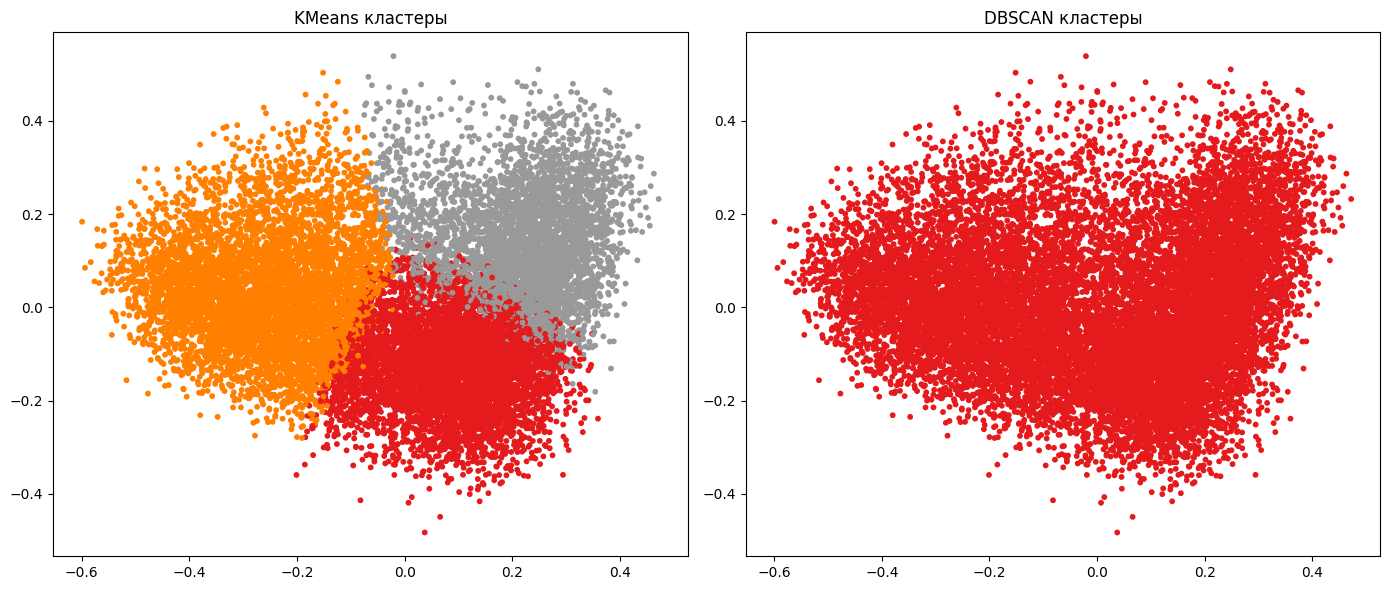

In [73]:
# Визуализация кластеров (PCA)
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(reduced[:, 0], reduced[:, 1], c=df['kmeans_label'], cmap='Set1', s=10)
plt.title('KMeans кластеры')

plt.subplot(1, 2, 2)
plt.scatter(reduced[:, 0], reduced[:, 1], c=df['dbscan_label'], cmap='Set1', s=10)
plt.title('DBSCAN кластеры')

plt.tight_layout()
plt.show()